In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import requests
import pandas as pd


from sklearn.metrics import mean_squared_error, mean_absolute_error


sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [59]:
api_key = "FWNg2ka2JJ3cGCK658LuphdOf59QgufSNvvGwBgf"

url = "https://api.eia.gov/v2/total-energy/data"


params = {
    "api_key": api_key,
    "frequency": "monthly",
    "start": "1998-01",
    "end": "2025-09",
    "length": 5000,
    
    "data[0]": "value",

    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    
    "facets[msn][]": ["ZWHDPC7", "ZWCDPC7"]
    
}

response = requests.get(url, params=params)

if response.status_code == 200:
    json_data = response.json()
    data_rows = json_data['response']['data']
    heating_cooling_days = pd.DataFrame(data_rows)
    

In [60]:
heating_cooling_days

,period,msn,seriesDescription,value,unit
0,2025-08,ZWCDPC7,"Cooling Degree-Days, West South Central in Number",567,Number
1,2025-08,ZWHDPC7,"Heating Degree-Days, West South Central in Number",0,Number
2,2025-07,ZWCDPC7,"Cooling Degree-Days, West South Central in Number",565,Number
3,2025-07,ZWHDPC7,"Heating Degree-Days, West South Central in Number",0,Number
4,2025-06,ZWCDPC7,"Cooling Degree-Days, West South Central in Number",488,Number
...,...,...,...,...,...
659,1998-03,ZWHDPC7,"Heating Degree-Days, West South Central in Number",323,Number
660,1998-02,ZWCDPC7,"Cooling Degree-Days, West South Central in Number",15,Number
661,1998-02,ZWHDPC7,"Heating Degree-Days, West South Central in Number",378,Number
662,1998-01,ZWCDPC7,"Cooling Degree-Days, West South Central in Number",27,Number


In [61]:
heating_cooling_days['value'] = heating_cooling_days['value'].astype(int)
heating_cooling_days = heating_cooling_days.groupby('period')['value'].sum().reset_index()



heating_cooling_days['period'] = pd.to_datetime(heating_cooling_days['period'])

heating_cooling_days.set_index('period', inplace=True)
heating_cooling_days['year'] = heating_cooling_days.index.year
heating_cooling_days['month'] = heating_cooling_days.index.month

In [62]:
def load_and_process_data():
    
    #Yearly data
    gdp = pd.read_csv('TXNGSP.csv', parse_dates=['observation_date'], index_col='observation_date')
    gdp = gdp.asfreq('AS')
    gdp.columns = ['GDP'] 


    # Yearly data
    pop = pd.read_csv('TXPOP.csv', parse_dates=['observation_date'], index_col='observation_date')
    pop = pop.asfreq('AS')
    pop.columns = ['Population']


    # Monthly data. Needs to be yearly, so we resample
    cons = pd.read_csv('eia_monthly_data.csv')
    cons['Date'] = pd.to_datetime(cons[['year', 'month']].assign(day=1))
    cons.set_index('Date', inplace=True)
    cons = cons[['generation']]
    cons.columns = ['Electricity']
    cons = cons.resample('AS').sum()


    yearly_hcd = heating_cooling_days.groupby(heating_cooling_days.index.year)[['value']].sum()
    yearly_hcd.index = pd.to_datetime(yearly_hcd.index.astype(str))
    yearly_hcd.columns = ['HCD']


    return gdp, pop, cons, yearly_hcd


In [63]:
gdp, pop, cons, yearly_hcd = load_and_process_data()

df = gdp.join([pop, cons, yearly_hcd], how='inner')
df = df.dropna()


df_diff = df.diff().dropna()

df_pct_diff = df.pct_change().dropna() * 100

print("Data Loaded Successfully.")
print("df shape:", df.shape)
print("df_real_diff shape:", df_diff.shape)
print("df_percent_diff shape:", df_pct_diff.shape)
print("\nReal Differences (df_real_diff.head()):")
display(df_diff.head())
print("\nPercentage Differences (df_percent_diff.head()):")
display(df_pct_diff.head())

Data Loaded Successfully.
df shape: (24, 4)
df_real_diff shape: (23, 4)
df_percent_diff shape: (23, 4)

Real Differences (df_real_diff.head()):


,GDP,Population,Electricity,HCD
2002-01-01,16151.1,370.703,26097.06999,104.0
2003-01-01,44503.5,340.606,-12857.70600,-107.0
2004-01-01,80369.9,363.092,22198.89057,-176.0
2005-01-01,82515.2,384.100,12739.17978,108.0
2006-01-01,104490.6,581.457,7828.31113,-42.0



Percentage Differences (df_percent_diff.head()):


,GDP,Population,Electricity,HCD
2002-01-01,2.070107,1.738788,3.502210,2.212295
2003-01-01,5.588384,1.570313,-1.667110,-2.226847
2004-01-01,9.558051,1.648101,2.927071,-3.746275
2005-01-01,8.957061,1.715190,1.631976,2.388324
2006-01-01,10.410065,2.552699,0.986757,-0.907127


In [64]:
import plotly.express as px

fig = px.line(df_pct_diff)
fig.show()

In [65]:
df_diff

,GDP,Population,Electricity,HCD
2002-01-01,16151.1,370.703,26097.06999,104.0
2003-01-01,44503.5,340.606,-12857.70600,-107.0
2004-01-01,80369.9,363.092,22198.89057,-176.0
2005-01-01,82515.2,384.100,12739.17978,108.0
2006-01-01,104490.6,581.457,7828.31113,-42.0
2007-01-01,90328.5,472.403,9818.83562,-3.0
2008-01-01,54577.0,477.056,-1409.02912,41.0
2009-01-01,-73973.9,492.722,-15239.74292,116.0
2010-01-01,76492.7,440.136,29054.27344,462.0
2011-01-01,96116.1,403.607,47544.25093,22.0


In [66]:
df_diff.columns

Index(['GDP', 'Population', 'Electricity', 'HCD'], dtype='object')

In [67]:

import plotly.express as px

fig = px.line(df_diff, x=df_diff.index, y=['Lagged_GDP_scale', 'Electricity_scale', 'HCD_scale', 'GDP_scale'],
              title='Lagged GDP vs. Electricity',
              labels={'x': 'Date', 'value': 'Value'})
fig.update_layout(height=600, width=1000)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()



ValueError: All arguments should have the same length. The length of argument `y` is 4, whereas the length of previously-processed arguments ['index'] is 23

In [ ]:
import matplotlib.pyplot as plt

def find_highest_lagged_correlation(df, lagged_col='GDP', normal_col='Electricity', max_lag=12):
    highest_correlation = -1.0
    best_lag = None
    lagged_correlations = {}

    if lagged_col not in df.columns or normal_col not in df.columns:
        return None, None, {}

    for lag in range(0, max_lag + 1):
        lagged_entry = df[lagged_col].shift(lag)
        combined = pd.DataFrame({
            'lagged_entry': lagged_entry,
            'normal_entry': df[normal_col]
        }).dropna()

        if not combined.empty:
            correlation = combined['lagged_entry'].corr(combined['normal_entry'])
            lagged_correlations[lag] = correlation
            if correlation > highest_correlation:
                highest_correlation = correlation
                best_lag = lag
    
    return highest_correlation, best_lag, lagged_correlations

In [ ]:
import matplotlib.pyplot as plt

def find_highest_lagged_correlation(df, lagged_col='GDP', normal_col='Electricity', max_lag=12):
    highest_correlation = -1.0
    best_lag = None
    lagged_correlations = {}

    if lagged_col not in df.columns or normal_col not in df.columns:
        return None, None, {}

    for lag in range(0, max_lag + 1):
        lagged_entry = df[lagged_col].shift(lag)
        combined = pd.DataFrame({
            'lagged_entry': lagged_entry,
            'normal_entry': df[normal_col]
        }).dropna()

        if not combined.empty:
            correlation = combined['lagged_entry'].corr(combined['normal_entry'])
            lagged_correlations[lag] = correlation
            if correlation > highest_correlation:
                highest_correlation = correlation
                best_lag = lag
    
    return highest_correlation, best_lag, lagged_correlations

Highest correlation: 0.3242 at lag: 0


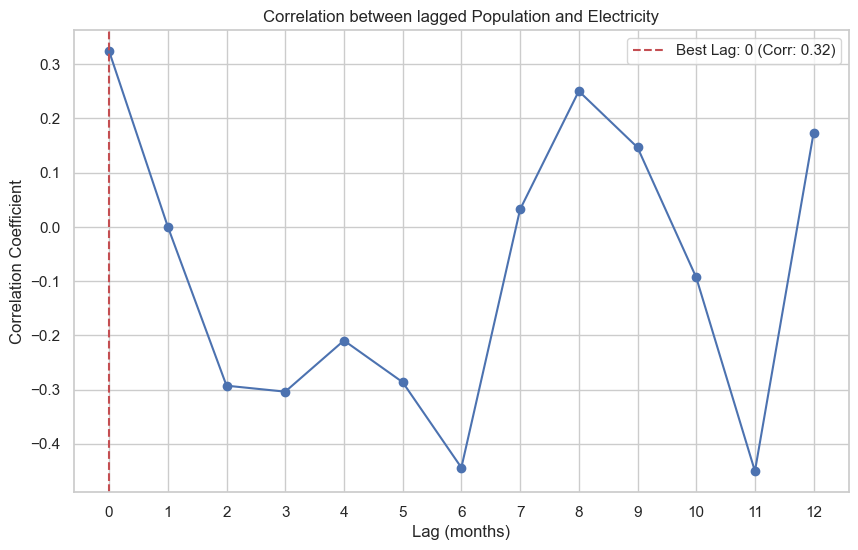

In [ ]:
lagged_col = 'Population'
normal_col = 'Electricity'
max_lag = 12

highest_corr, best_lag, all_correlations = find_highest_lagged_correlation(df_diff, lagged_col=lagged_col, normal_col=normal_col, max_lag=max_lag)
print(f"Highest correlation: {highest_corr:.4f} at lag: {best_lag}")


lags = list(all_correlations.keys())
correlations = list(all_correlations.values())

plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o', linestyle='-')
plt.title(f'Correlation between lagged {lagged_col} and {normal_col}')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')
plt.xticks(lags)
plt.grid(True)
plt.axvline(x=best_lag, color='r', linestyle='--', label=f'Best Lag: {best_lag} (Corr: {highest_corr:.2f})')
plt.legend()
plt.show()



Highest correlation: 0.7044 at lag: 0


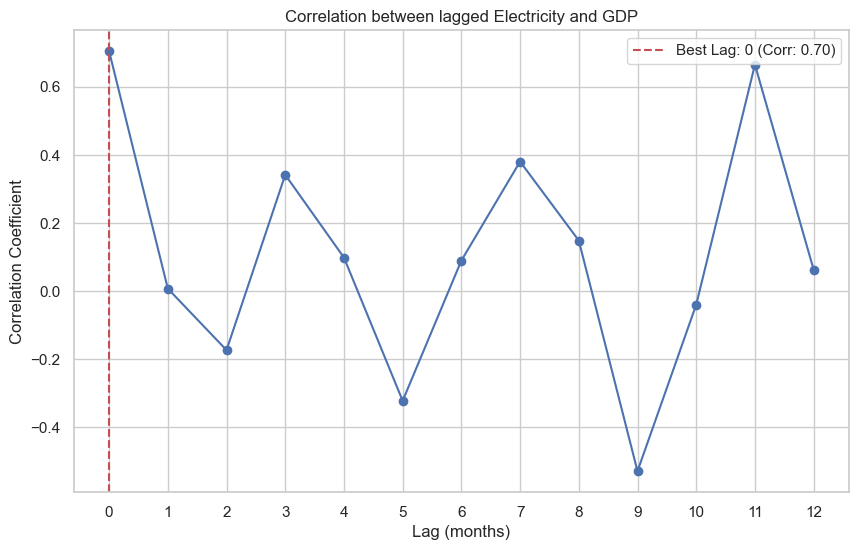

In [ ]:
lagged_col = 'Electricity'
normal_col = 'GDP'
max_lag = 12

highest_corr, best_lag, all_correlations = find_highest_lagged_correlation(df_diff, lagged_col=lagged_col, normal_col=normal_col, max_lag=max_lag)
print(f"Highest correlation: {highest_corr:.4f} at lag: {best_lag}")

# Plotting the lagged correlations
if all_correlations:
    lags = list(all_correlations.keys())
    correlations = list(all_correlations.values())

    plt.figure(figsize=(10, 6))
    plt.plot(lags, correlations, marker='o', linestyle='-')
    plt.title(f'Correlation between lagged {lagged_col} and {normal_col}')
    plt.xlabel('Lag (months)')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(lags)
    plt.grid(True)
    plt.axvline(x=best_lag, color='r', linestyle='--', label=f'Best Lag: {best_lag} (Corr: {highest_corr:.2f})')
    plt.legend()
    plt.show()
else:
    print("No correlations to plot.")


Highest correlation: 0.5765 at lag: 0


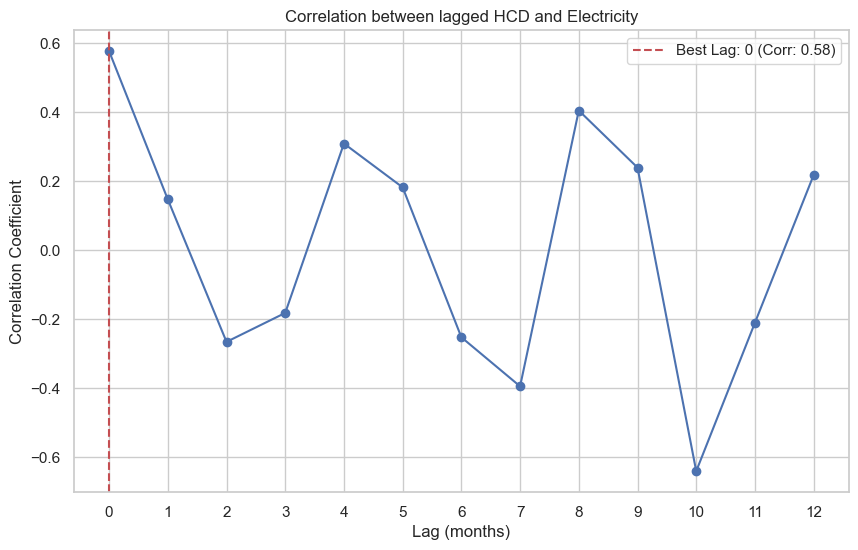

In [ ]:
lagged_col = 'HCD'
normal_col = 'Electricity'
max_lag = 12

highest_corr, best_lag, all_correlations = find_highest_lagged_correlation(df_diff, lagged_col=lagged_col, normal_col=normal_col, max_lag=max_lag)
print(f"Highest correlation: {highest_corr:.4f} at lag: {best_lag}")

# Plotting the lagged correlations
if all_correlations:
    lags = list(all_correlations.keys())
    correlations = list(all_correlations.values())

    plt.figure(figsize=(10, 6))
    plt.plot(lags, correlations, marker='o', linestyle='-')
    plt.title(f'Correlation between lagged {lagged_col} and {normal_col}')
    plt.xlabel('Lag (months)')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(lags)
    plt.grid(True)
    plt.axvline(x=best_lag, color='r', linestyle='--', label=f'Best Lag: {best_lag} (Corr: {highest_corr:.2f})')
    plt.legend()
    plt.show()
else:
    print("No correlations to plot.")


In [ ]:
df_diff['Lagged_GDP'] = df_diff['GDP'].shift(1)
df_diff.dropna(inplace=True)

In [ ]:
from xgboost import XGBRegressor
X = df_diff[['Lagged_GDP', 'HCD']]
y = df_diff['Electricity']

# Split Data (Last 24 months as test set)
test_size = 5
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

# Train Model
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nTrain R2: {r2_train:.3f}")
print(f"Test R2: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.2f}")

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nModel Coefficients:")
print(coef_df)

Train Shape: (15, 2)
Test Shape: (5, 2)

Train R2: 0.371
Test R2: 0.070
Test RMSE: 33711.50

Model Coefficients:
      Feature  Coefficient
0  Lagged_GDP     0.007327
1         HCD    33.449840


In [ ]:
df_diff


,GDP,Population,Electricity,HCD,Lagged_GDP
2005-01-01,82515.2,384.100,12739.17978,108.0,80369.9
2006-01-01,104490.6,581.457,7828.31113,-42.0,82515.2
2007-01-01,90328.5,472.403,9818.83562,-3.0,104490.6
2008-01-01,54577.0,477.056,-1409.02912,41.0,90328.5
2009-01-01,-73973.9,492.722,-15239.74292,116.0,54577.0
2010-01-01,76492.7,440.136,29054.27344,462.0,-73973.9
2011-01-01,96116.1,403.607,47544.25093,22.0,76492.7
2012-01-01,77811.1,438.616,-11309.32377,-664.0,96116.1
2013-01-01,97193.9,395.526,7135.31182,299.0,77811.1
2014-01-01,65395.7,483.446,8499.00434,33.0,97193.9
